## Build IPV3 Model on Regions

## 0. Preparation


In [1]:
import numpy as np
import os
import keras
import settings
import myutils
import cv2 as cv
from data_managers import load_train_dataset, load_test_dataset, make_submission
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

# config
seed = 7
np.random.seed(seed)
keras.backend.set_image_dim_ordering('th')

# setting
IMG_SIZE = (299, 299)
BATCH_SIZE = 32
REGION_TRAINING_DIR = "../dataset/fish_regions"
MODEL_FILE_NAME = '../models/ipv3_region/ipv3_region-15--0.03--0.99.h5'
NB_TRAIN_SAMPLES = 20000
NB_EPOCH = 16

# set some settings for region proposl
scale = 500
min_pixels = 1000

# some value will be used
name_to_int = settings.class_names_to_int
classes_list = myutils.sort_by_value(name_to_int)
int_to_name = {value: key for key, value in name_to_int.items()}
print "classes_list:", classes_list
print int_to_name

classes_list: ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
{0: 'ALB', 1: 'BET', 2: 'DOL', 3: 'LAG', 4: 'NoF', 5: 'OTHER', 6: 'SHARK', 7: 'YFT'}


Using TensorFlow backend.


## 1. Load Dataset

There is no need to splid dataset to training set and validation set, because there are many similar regions in the datasets that come from the same images.

The dataset is too large to load it into memory at one time, so loading it by a generator.

The dataset is:

    ../dataset/fish_regions/
                    |- ALB/
                    |- BET/
                    |- DOL/
                    |- LAG/
                    |- NoF/
                    |- OTHER/
                    |- SHARK/
                    |- YFT/

In [2]:
region_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.1,
        zoom_range=0.1,
        rotation_range=10.,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
    )

region_generator = region_datagen.flow_from_directory(
        REGION_TRAINING_DIR,
        target_size = IMG_SIZE,
        batch_size = BATCH_SIZE,
        shuffle = True,
        classes = classes_list,
        class_mode = 'categorical'
)

Found 21501 images belonging to 8 classes.


Show one batch of region images

(32, 3, 299, 299) (32, 8)


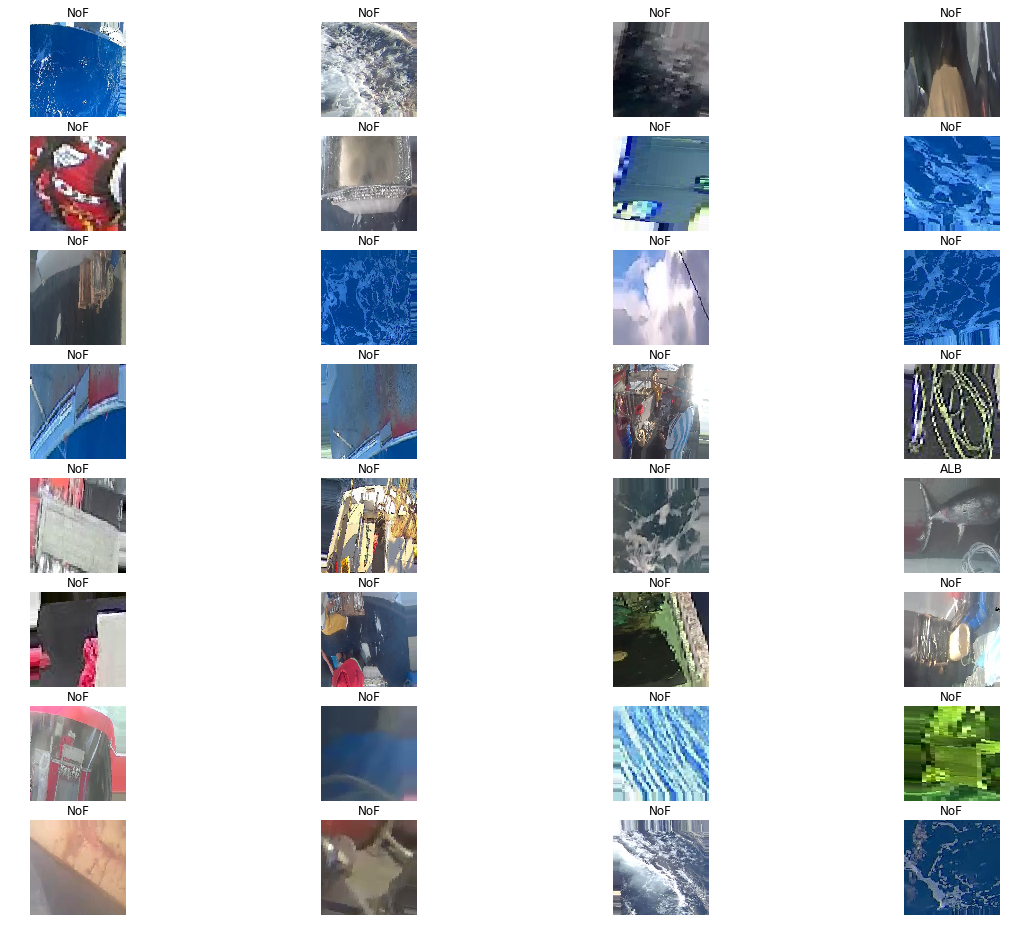

In [3]:
# draw one batch of region
for regions_batch, categorical_batch in region_generator:
    print regions_batch.shape, categorical_batch.shape

    plt.figure(figsize=(20, 16))
    for i in range(len(regions_batch)):
        plt.subplot(8, 4, 1+i)
        plt.imshow(np.rollaxis(regions_batch[i], 0, 3))
        plt.title(str(int_to_name[np.argmax(categorical_batch[i])]))
        plt.axis('off')
    plt.show()
    break

## 2. Build IPV3 Model

In [4]:
# build ipv3
ipv3 = myutils.create_inception_v3(input_size=IMG_SIZE)

/Users/liuweijie/WorkSpace/FisheriesMonitor/.env/lib/python2.7/site-packages/keras/applications/inception_v3.py:291: UserWarning: You are using the TensorFlow backend, yet you are using the Theano image dimension ordering convention (`image_dim_ordering="th"`). For best performance, set `image_dim_ordering="tf"` in your Keras config at ~/.keras/keras.json.
  warnings.warn('You are using the TensorFlow backend, yet you '


## 3. Training or Loading Model

Training process would cost a long time. You can pass thie process if the model has been trained, and load the model directly

In [5]:
if os.path.exists(MODEL_FILE_NAME):   
    ipv3.load_weights(MODEL_FILE_NAME)
    print "IPV3 has been loaded successfully"

else:
    # training model
    mode_weights_file = "../models/ipv3_region/ipv3_region-{epoch:02d}--{loss:.2f}--{acc:.2f}.h5"
    checkpoint = ModelCheckpoint(mode_weights_file, monitor='loss', verbose = 1, save_best_only = True)
    history = ipv3.fit_generator(
        region_generator,
        samples_per_epoch=NB_TRAIN_SAMPLES,
        nb_epoch=NB_EPOCH,
        callbacks=[checkpoint],
        verbose=1
    )
    print "Bset Model has been store at ", mode_weights_file

IPV3 has been loaded successfully


In [6]:
# plot training history
if 'history' in locals().keys():
    plt.subplot(111)
    plt.plot(history.history['acc'])
    plt.plot(history.history['loss'])
    plt.ylabel('acc and loss')
    plt.xlabel('epoch')
    plt.title('model train history')
    plt.show()

(32, 3, 299, 299) (32, 8)


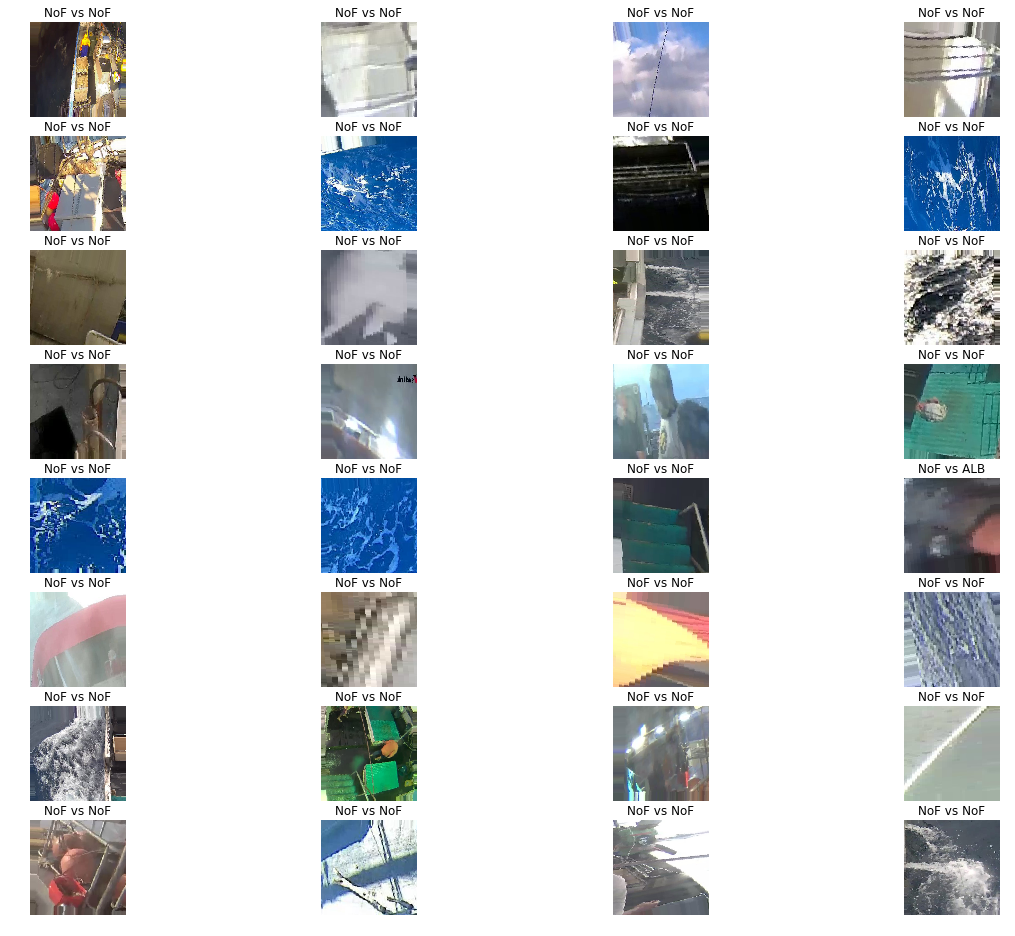

In [7]:
# evaluate model
for regions_batch, categorical_batch in region_generator:
    print regions_batch.shape, categorical_batch.shape

    plt.figure(figsize=(20, 16))
    for i in range(len(regions_batch)):
        plt.subplot(8, 4, 1+i)
        plt.imshow(np.rollaxis(regions_batch[i], 0, 3))
        pre = ipv3.predict(regions_batch[i].reshape(1, 3, 299, 299))
        name = int_to_name[np.argmax(pre)]
        
        plt.title(str(int_to_name[np.argmax(categorical_batch[i])]) + ' vs ' + str(name))
        plt.axis('off')
    plt.show()
    break

## 4. Predict Example

In [7]:
# load test dataset
test_imgs, imgs_name = load_test_dataset(img_size=IMG_SIZE)

Let's test an example to see the perference of predict by region proposal.

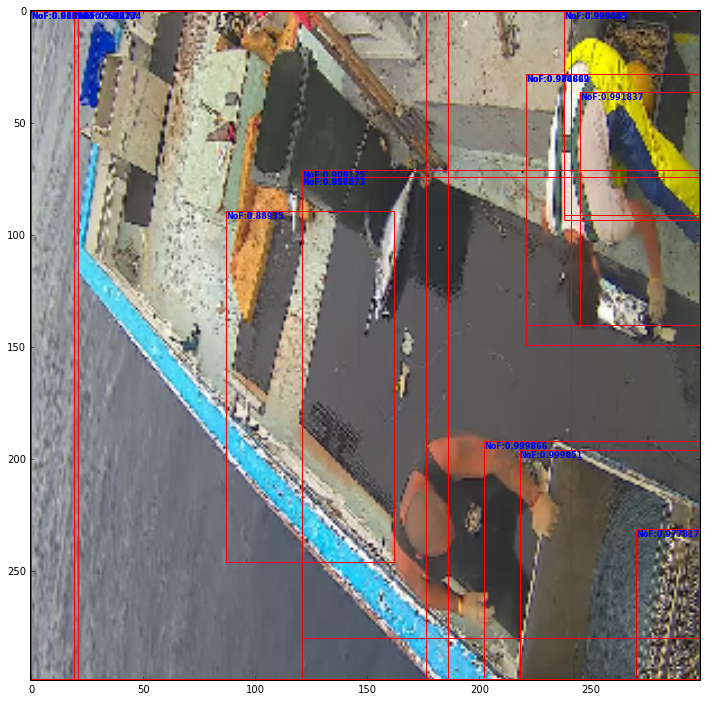

In [12]:
# take an image as example
fisher_img = test_imgs[444].astype('uint8')
nb_multi_view = 5

# draw img
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(np.rollaxis(fisher_img, 0, 3).astype('uint8'))

# extract regions
regions = myutils.extract_regions(fisher_img, scale=scale, min_pixels=min_pixels)

# for each regions
for x, y, w, h in regions:
    
    # warp region to fix size
    region = fisher_img[:, y: y+h, x: x+w]
    
    region = myutils.image_resize(region, IMG_SIZE)
    
    region = region.reshape(1, 3, IMG_SIZE[1], IMG_SIZE[0])
    
    # predict by multi view
    test_region_gen = region_datagen.flow(region, np.zeros((1, )), batch_size=nb_multi_view, seed=seed)
    Y_pre = ipv3.predict_generator(test_region_gen, nb_multi_view)
    Y_pre = np.average(Y_pre, axis=0)
    
    # predict by one view
    # Y_pre = ipv3.predict(region/255.0)[0]
    
    # get classification score
    class_idx = np.argmax(Y_pre)
    class_score = Y_pre[class_idx]
    label_str = str(int_to_name[class_idx]) + ':' + str(class_score)

    # draw boxes
#     if int_to_name[class_idx] != 'NoF':
    rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=1)
    ax.add_patch(rect)
    ax.annotate(label_str, (x, y), color='b', weight='bold', fontsize=8, ha='left', va='top')
        
plt.show()

## 5.Predict ALL

In [11]:
def predict_by_regions(model, image, regions, multiview=False, nb_multiview=5, verbose=0, seed=7, background_idx=4):
    
    scores_list = []
    all_scores_list = []
    for x, y, w, h in regions:
    
        # warp region to fix size
        region = image[:, y: y+h, x: x+w]
        region = myutils.image_resize(region, IMG_SIZE)
        region = region.reshape(1, 3, IMG_SIZE[1], IMG_SIZE[0])
        
        if multiview:

            # predict by multi view
            test_region_gen = region_datagen.flow(region, np.zeros((1, )), batch_size=nb_multiview, seed=seed)
            Y_pre = model.predict_generator(test_region_gen, nb_multiview)
            Y_pre = np.average(Y_pre, axis=0)
        
        else:
            
            # directly predict without multiview
            Y_pre = model.predict(region/255)[0]
                    
        all_scores_list.append(Y_pre)
        
        max_idx = np.argmax(Y_pre)
        if max_idx == background_idx:  # exclude background
            continue
        else:
            scores_list.append(Y_pre)

    scores_lit = np.array(scores_list)
    all_scores_lit = np.array(all_scores_list)
    
    if len(scores_list) > 0:
        Y_ret = np.average(scores_lit, axis=0)
    else:
        Y_ret = np.average(all_scores_lit, axis=0)
    
    return Y_ret

Let's predict one image to make sure there ia no bug of this function

In [12]:
img = test_imgs[0]
regions = myutils.extract_regions(img, scale=scale, min_pixels=min_pixels)
y = predict_by_regions(ipv3, img, regions, multiview=False, seed=seed, background_idx=4)
print y

[  7.01741874e-03   5.87628107e-04   2.53643611e-05   1.14988306e-05
   9.89706159e-01   2.10394850e-03   9.76020456e-05   4.50365042e-04]


Predict all images. it's speed is about 5 seconds per img if multiview is true.

In [13]:
results = []
num_imgs = len(test_imgs)
for i in range(num_imgs):
    img = test_imgs[i]
    regions = myutils.extract_regions(img, scale=scale, min_pixels=min_pixels)
    y = predict_by_regions(ipv3, img, regions, multiview=True, seed=seed, background_idx=4)
    results.append(y)
    
    name = int_to_name[np.argmax(y)]
    print i, num_imgs, name

results = np.array(results)

0 1000 NoF
1 1000 YFT
2 1000 ALB
3 1000 NoF
4 1000 YFT
5 1000 NoF
6 1000 ALB
7 1000 ALB
8 1000 NoF
9 1000 DOL
10 1000 NoF
11 1000 NoF
12 1000 OTHER
13 1000 BET
14 1000 NoF
15 1000 ALB
16 1000 NoF
17 1000 NoF
18 1000 NoF
19 1000 NoF
20 1000 YFT
21 1000 ALB
22 1000 ALB
23 1000 ALB
24 1000 ALB
25 1000 NoF
26 1000 NoF
27 1000 ALB
28 1000 OTHER
29 1000 DOL
30 1000 LAG
31 1000 NoF
32 1000 LAG
33 1000 ALB
34 1000 NoF
35 1000 ALB
36 1000 NoF
37 1000 NoF
38 1000 ALB
39 1000 YFT
40 1000 ALB
41 1000 ALB
42 1000 NoF
43 1000 YFT
44 1000 DOL
45 1000 NoF
46 1000 NoF
47 1000 LAG
48 1000 NoF
49 1000 DOL
50 1000 NoF
51 1000 NoF
52 1000 DOL
53 1000 NoF
54 1000 NoF
55 1000 ALB
56 1000 ALB
57 1000 NoF
58 1000 LAG
59 1000 ALB
60 1000 NoF
61 1000 NoF
62 1000 NoF
63 1000 NoF
64 1000 NoF
65 1000 ALB
66 1000 ALB
67 1000 NoF
68 1000 ALB
69 1000 NoF
70 1000 DOL
71 1000 NoF
72 1000 NoF
73 1000 ALB
74 1000 ALB
75 1000 NoF
76 1000 ALB
77 1000 NoF
78 1000 ALB
79 1000 NoF
80 1000 NoF
81 1000 ALB
82 1000 ALB
83 1000 No

## Make Submission

In [14]:
submissionfile = "../results/submission_ipv3_region-15-multiview.csv"
make_submission(submissionfile, results, imgs_name)

Submission file has been generated: ../results/submission_ipv3_region-15-multiview.csv
